In [1]:
import io

import numpy as np
import matplotlib.pyplot as plt

from ase.io import read, write

from molent.molent import entropy, binary_similarity, cosine_similarity

# Read Data from QM9 Dataset

The dataset can be downloaded from https://doi.org/10.6084/m9.figshare.c.978904.v5

In [3]:
qm9_dir = '../../../QM9/dsgdb9nsd.xyz/' # adjust to your QM9 directory

In [4]:
from molent.tools import cleanup_qm9_xyz

all_atoms = []
all_smiles = []

for i in range(1,185):
    ind, gdb_smi, relax_smi = cleanup_qm9_xyz(qm9_dir+'dsgdb9nsd_%06i.xyz' % i)
    
    all_atoms.append(read(io.StringIO(ind), format='xyz'))
    all_smiles.append(relax_smi)

# Fragment Smiles &rarr; Entropies

In [5]:
from molent.molent import fragment_smiles

N_rad = 3 # the only parameter is the "size" of the local environments (no. of bonds from atom) 

fragsmiles = fragment_smiles(all_smiles, N_rad = N_rad, useHs = True)

In [6]:
smiles_entropies = [entropy(binary_similarity(fs)) for fs in fragsmiles]

# SOAP &rarr; Entropies

In [7]:
from dscribe.descriptors import SOAP

# SOAP parameters
species = ["C", "H", "O", "N", "F"]
r_cut = 6.
n_max = 10
l_max = 6

# setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
)

soap_mol = soap.create(all_atoms)

In [8]:
zeta = 16

soap_entropies = []
for i in range(len(all_atoms)):
    at_nums = all_atoms[i].get_atomic_numbers()
    S = cosine_similarity(soap_mol[i], at_nums=at_nums)**zeta
    soap_entropies.append(entropy(S))

# Comparison

In [9]:
# some small molecules and their information entropy
# see D.Sh. Sabirov / Computational and Theoretical Chemistry 1123 (2018) 169–179
molecule_entropies = {
    'C': 0.722, # CH4
    'N': 0.811, # NH3
    'O': 0.918, # H2O
    'C#C': 1.000, # C2H2    
    'C#N': 1.585, # HCN
    'C=O': 1.5, # CH2O    
    'CC': 0.811, # C2H6
    'CO': 1.792, # CH3OH        
    'CCO': 2.419, # CH3CH2OH
    'COC': 1.224, # CH3OCH3
    'CCC': 1.685, # CH3CH2CH3
    'CC(C)(C)C': 1.086, # neopentane
    'CCCCC': 2.351 # pentane
}

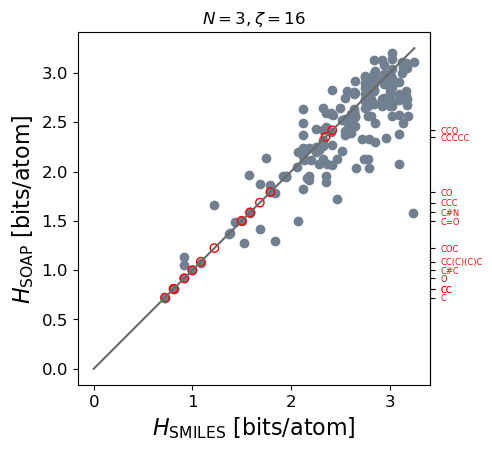

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(smiles_entropies, soap_entropies, color='slategrey')
ax.scatter(list(molecule_entropies.values()), list(molecule_entropies.values()), 
           color='red', marker='o', facecolor='none')
ax.plot([0, np.max(smiles_entropies)], [0, np.max(smiles_entropies)], color='dimgrey')

ax_yr = ax.secondary_yaxis('right')
ax_yr.set_ticks(list(molecule_entropies.values()), labels=list(molecule_entropies.keys()), 
                color='red', fontsize=6)

ax.set_title(r'$N=%i, \zeta=%i$' % (N_rad,zeta), fontsize=12)
ax.set_aspect('equal')
ax.set_ylabel(r'$H_{\rm SOAP}$ [bits/atom]', fontsize=16)
ax.set_xlabel(r'$H_{\rm SMILES}$ [bits/atom]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()
#plt.savefig('ent_soap_smiles_zeta%i.pdf' % zeta)

# Kullback-Leibler divergence

In [13]:
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds
from molent.molent import atomic_smiles, cross_entropy

all_kl_divs = []
not_matching = 0
for i in range(len(all_atoms)):
    at_nums = all_atoms[i].get_atomic_numbers()

    ## xyz_to_mol
    xyz_string = io.StringIO()
    write(xyz_string, all_atoms[i], format='xyz')
    raw_mol = Chem.MolFromXYZBlock(xyz_string.getvalue())
    xyz_mol = Chem.Mol(raw_mol)
    rdDetermineBonds.DetermineBonds(xyz_mol, charge=0)
    ##
    
    cm = Chem.RemoveHs(xyz_mol)
    osmi = Chem.MolToSmiles(cm, isomericSmiles=True)
    smi = Chem.CanonSmiles(all_smiles[i])

    if osmi != smi:
        print('SMILES not matching: ', osmi, smi)
        not_matching += 1
    else:
        smiles = atomic_smiles(xyz_mol, max_radius=N_rad)
        S_smiles = binary_similarity(smiles)
        H_smiles = entropy(S_smiles)

        kl_divs = []
        for zeta in range(8,160,8):
            S_soap = cosine_similarity(soap_mol[i], at_nums=at_nums)**zeta

            kl_divs.append(cross_entropy(S_smiles, S_soap) - H_smiles)

        all_kl_divs.append(kl_divs)
        
print('-- %i / %i SMILES did not match.' % (not_matching, len(all_atoms)))
        
# average the KL divergencies over the molecules
kl_divergencies = np.mean(np.array(all_kl_divs).real, axis=0)

SMILES not matching:  [H]/N=C(\N)C#N N#CC(=N)N
SMILES not matching:  [H]/N=C(\N)C=O N=C(N)C=O
SMILES not matching:  [H]/N=C(\C)OC CO[C](C)[NH]
SMILES not matching:  [H]/N=C1/CCO1 [NH][C]1CCO1
SMILES not matching:  [H]/N=C/NC=O N=CNC=O
SMILES not matching:  [H]/N=C/OC=O [NH][CH]OC=O
SMILES not matching:  C/N=C/OC CN=COC
SMILES not matching:  C#C/C(C)=N/O C#CC(C)=NO
SMILES not matching:  C/C(CO)=N\O CC(CO)=NO
SMILES not matching:  CC/C(C)=N/O CCC(C)=NO
-- 10 / 184 SMILES did not match.


In [14]:
zeta = 64

soap_entropies = []
for i in range(len(all_atoms)):
    at_nums = all_atoms[i].get_atomic_numbers()
    S = cosine_similarity(soap_mol[i], at_nums=at_nums)**zeta
    soap_entropies.append(entropy(S))

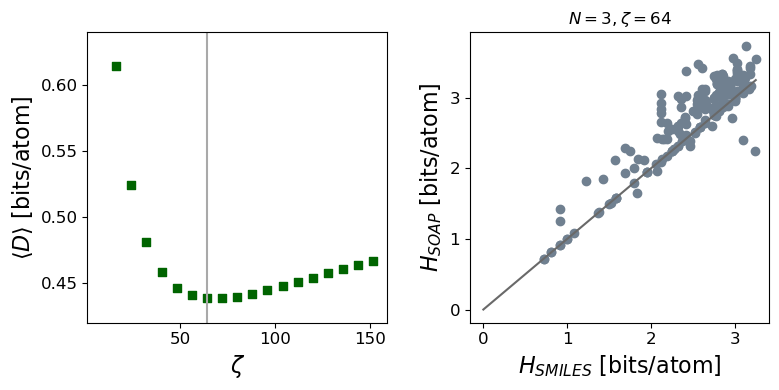

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax2.scatter(smiles_entropies, soap_entropies, color='slategrey')
ax2.plot([0, np.max(smiles_entropies)], [0, np.max(smiles_entropies)], color='dimgrey')

ax2.set_title(r'$N=%i, \zeta=%i$' % (N_rad,zeta))
ax2.set_ylabel(r'$H_{SOAP}$ [bits/atom]', fontsize=16)
ax2.set_xlabel(r'$H_{SMILES}$ [bits/atom]', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1.scatter(range(8,160,8), kl_divergencies, color='darkgreen', marker='s')
ax1.axvline(x=64, color='darkgrey')
ax1.set_ylim((0.42,0.64))

ax1.set_xlabel(r'$\zeta$', fontsize=16)
ax1.set_ylabel(r'$\langle D\rangle$ [bits/atom]', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()
#plt.savefig('kldiv_ent_soap_smiles_zeta%i.pdf' % zeta)